<a href="https://colab.research.google.com/github/iamBehzad/Machin-Vision-and-Image-Processing/blob/main/Object_Detection_and_Tracking_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zebra Found
[186, 136, 344, 241]


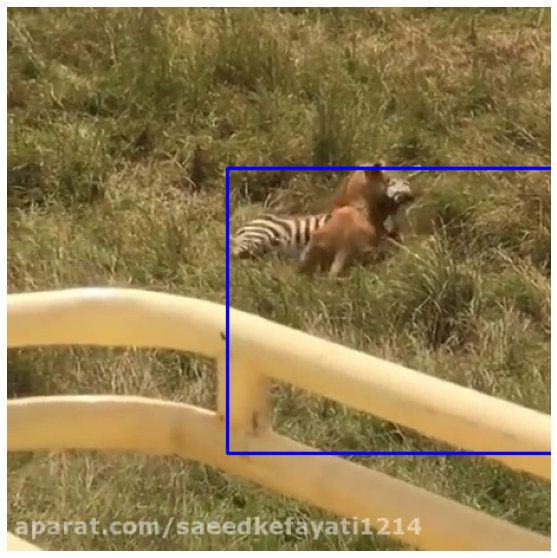

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random


textGraph = "model/tensorflow/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
modelWeights = "model/tensorflow/frozen_inference_graph_coco.pb"

# Download Link : https://drive.google.com/drive/folders/1TLiJHxHylT_lI2iP7FKyW05miAMsS8-u
# Load the network
net = cv2.dnn.readNetFromTensorflow(modelWeights, textGraph);
# Initialize the parameters
confThreshold = 0.5  # Confidence threshold
maskThreshold = 0.3  # Mask threshold

video_input_file_name = "videos/zebra.mp4"

def drawRectangle(frame, bbox):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)

def displayRectangle(frame, bbox):
    plt.figure(figsize=(20,10))
    frameCopy = frame.copy()
    drawRectangle(frameCopy, bbox)
    frameCopy = cv2.cvtColor(frameCopy, cv2.COLOR_RGB2BGR)
    plt.imshow(frameCopy); plt.axis('off')    
    
# Read video
video = cv2.VideoCapture(video_input_file_name)
video.set(cv2.CAP_PROP_POS_FRAMES, 200)
ret, frame = video.read()

# Exit if video not opened
if not video.isOpened():
    print("Could not open video")
else : 
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

isfound=0
box=[0,0,0,0]
while not isfound:

    ret, frame = video.read()
    if not ret:
        break

    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(frame, swapRB=True, crop=False)
    # Set the input to the network
    net.setInput(blob)
    # Run the forward pass to get output from the output layers
    boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

    # Extract the bounding box and mask for each of the detected objects
    # Output size of masks is NxCxHxW where
    # N - number of detected boxes
    # C - number of classes (excluding background)
    # HxW - segmentation shape
    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    frameH = frame.shape[0]
    frameW = frame.shape[1]  

    for i in range(numDetections):
        box = boxes[0, 0, i]
        mask = masks[i]
        score = box[2]
        if score > confThreshold:
            classId = int(box[1])
            if classId==23:
                print("Zebra Found")
                # Extract the bounding box
                left = int(frameW * box[3])
                top = int(frameH * box[4])
                right = int(frameW * box[5])
                bottom = int(frameH * box[6])

                left = max(0, min(left, frameW - 1))
                top = max(0, min(top, frameH - 1))
                right = max(0, min(right, frameW - 1))
                bottom = max(0, min(bottom, frameH - 1))

                box = [left, top, right, bottom]
                isfound=1
                break;
                
track_window=(box[0],box[1],box[2],box[3])
print(box)
displayRectangle(frame,track_window)

# set up the ROI for tracking
roi = frame[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]

hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)
# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
while(1):
    ret, frame = video.read()
    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # apply camshift to get the new location
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)
        # Draw it on image
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv2.polylines(frame,[pts],True, 255,2)
        cv2.imshow('img2',img2)
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break
    else:
        break
cv2.destroyAllWindows()